In [15]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# master loader for the bag, returns the messages on topic_name in time order
def bag_loader(path, map_and_append_msg, topic_name = 'robot_state', normalize = ''):
    # map_and_append_msgs is a function handle which should be written for each type.  There are some for joint state and robot state below
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs is 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    t = [tt-t[0] for tt in t]

    msgs_in_order = {}
    for key in msgs.keys():
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize is not '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs


def map_joint_state(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('pos', 'name'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['name'].append(msg.name)
    return prev_msgs

def map_wrench(msg, prev_msgs):
    #print(f"Debug: {len(prev_msgs)}")
    if len(prev_msgs) is 0:
        prev_msgs['force'] = []
    prev_msgs['force'].append(np.array([msg.wrench.force.x, 
                                        msg.wrench.force.y,
                                        msg.wrench.force.z]))
    return prev_msgs

def map_point_msgs(msg, prev_msgs):
    #print(f"Debug: {len(prev_msgs)}")
    if len(prev_msgs) is 0:
        prev_msgs['position'] = []
    #print(f"Debug: {msg.pose.__dir__()}")
    prev_msgs['position'].append(np.array([msg.pose.position.x, 
                                        msg.pose.position.y,
                                        msg.pose.position.z]))
    return prev_msgs
    

def map_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('K', 'B', 'M', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['K'].append(msg.position)
    prev_msgs['B'].append(msg.velocity)
    prev_msgs['M'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])

def map_delta_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('dK', 'dB', 'dM', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['dK'].append(msg.position)
    prev_msgs['dB'].append(msg.velocity)
    prev_msgs['dM'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])
    

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="

In [32]:
import yaml
from rosbag.bag import Bag
bag_path = '/home/christian/Projects/contact_monitoring/data/plug_threading_online.bag'
bag_dict = yaml.load(Bag(bag_path, 'r')._get_yaml_info(), Loader=yaml.Loader)
print("Keys are")
for k in bag_dict['topics']:
    #print(f"\n{k}:\n{bag_dict[k]}")
    print(f"\n:\n{k}")


Keys are

:
{'topic': '/cartesian_compliance_controller/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_x/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_x/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_y/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_y/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_z/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic':

In [16]:
### Comparing with and without variance in contact
# %matplotlib
path = '/home/christian/Projects/contact_monitoring/data/'
bag = 'plug_threading_online.bag'

contact_state_msgs = bag_loader(path+bag, map_joint_state, topic_name = 'contact_mode')
FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'wrench')
des_FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'target_wrench')
des_pose_msgs = bag_loader(path+bag, map_point_msgs, topic_name = 'target_frame')

Loading ros bag /home/christian/Projects/contact_monitoring/data/plug_threading_online.bag  with 41228 msgs on topic /target_frame


Loading ros bag /home/christian/Projects/contact_monitoring/data/plug_threading_online.bag  with 0 msgs on topic /robot_state


UnboundLocalError: local variable 't_in_order' referenced before assignment

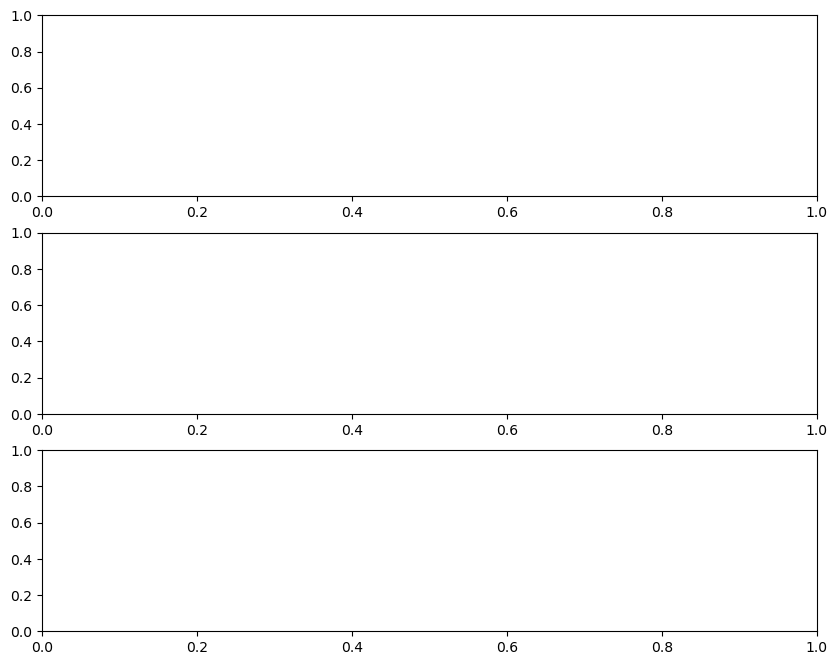

In [14]:
### Comparing with and without variance in contact
# %matplotlib
path = '/home/christian/Projects/contact_monitoring/data/'
baggies = [ 'plug_threading_online.bag'
          ]  
topics = [ 'contact_mode',  # JointState message with name, position where positoin is the similarity
           # 'tool_data', 
           'wrench' # WrenchStamped FT measurements
           'target_frame', # desired pose for admittance ctrl
           'target_wrench', # desired force for admittance trl
         ]
fig, axs = plt.subplots(3, figsize=(10,8))
#fig.suptitle("Contact with GP-MPC")
cols = ['r', 'b', 'b-.', 'k', 'k-.']
for bag, name in zip(baggies, namies):
    col = cols.pop(0)
    contact_state_msgs = bag_loader(path+bag, map_joint_state, topic_name = 'contact_mode')
    FT_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'wrench')
    des_FT_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'target_wrench')
    des_pose_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'target_frame')

    

    ind = 2
    #plt.figure(figsize=(6,3), dpi= 100)
    
    axs[0].plot(-state_msgs['pos'][2,:], delta_imp_msgs['Fd'][ind], col, label = name)
    #axs[0].plot(imp_msgs['t'], delta_imp_msgs['Fd'][ind], col, label = name)
    axs[1].plot(-state_msgs['pos'][2,:], imp_msgs['B'][ind], col)
    axs[2].plot(-state_msgs['pos'][2,:], imp_msgs['M'][ind], col)

axs[0].legend()
for i in range(3): axs[i].grid(True)
#for i in range(3): axs[i].set_xlim([-0.525,-0.343])
plt.xlabel('Time (sec)')
axs[0].set(ylabel='F^r (N)', title = 'Desired force')
axs[1].set(ylabel='D (Nm/s))', title = 'Imp damping')
axs[2].set(ylabel='M (kg)', title = 'Imp inertia')
plt.tight_layout()
plt.show()


In [4]:
# Plotting rail assembly over time
# %matplotlib

bag = 'rail_valid_3_4.bag'

fig, axs = plt.subplots(3, figsize=(10,8))
fig.suptitle("Rail assembly with GP-MPC")
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
msgs = bag_loader(bag, map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
dM = msgs['dM']
Fd = msgs['Fd']
dB = msgs['dB']
t = msgs['t']


dirs = ['X', 'Y', 'Z']
for ind in range(3):
    col = cols.pop(0)
#plt.figure(figsize=(6,3), dpi= 100)
    axs[0].plot(t, Fd[ind], col, label = dirs.pop(0))
    axs[1].plot(t, dB[ind], col)
    axs[2].plot(t, dM[ind], col)

axs[0].legend()
for i in range(3): axs[i].grid(True)
#for i in range(3): axs[i].set_xlim([0,6])
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Fd (N)', title = 'Desired force')
axs[1].set(ylabel='dB (Nm/s))', title = 'Change imp damping')
axs[2].set(ylabel='dM (kg)', title = 'Change imp inertia')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'rail_valid_3_4.bag'

Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_1.bag  with 1233 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_1.bag  with 1234 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_1.bag  with 409 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_2.bag  with 1222 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_2.bag  with 1221 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_2.bag  with 390 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_3.bag  with 1322 msgs on topic /robot_state
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_3.bag  with 1323 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/soft_wd_3.bag  with 436 msgs on topic /delta_impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/sof

Loading ros bag ../data/contact_var2/valid_18_07/hard_low_3.bag  with 1530 msgs on topic /impedance_gains
Loading ros bag ../data/contact_var2/valid_18_07/hard_low_3.bag  with 429 msgs on topic /delta_impedance_gains


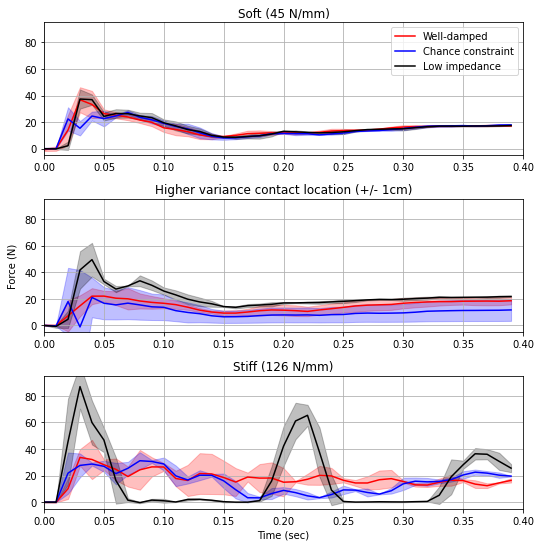

In [2]:
### Contact variance/stiffness

path = '../data/contact_var2/valid_18_07/'
list_of_baggies = [[ 'soft_wd_', 'soft_cc_', 'soft_low_'],
           [ 'var_wd_cc_', 'var_low_', 'var_wd_'],  
           [  'hard_cc_', 'hard_wd_', 'hard_low_']]
datasets = ['Soft (45 N/mm)', 'Higher variance contact location (+/- 1cm)', 'Stiff (126 N/mm)']
namies = [ 'Well-damped', 'Chance constraint', 'Low impedance']

fig, axs = plt.subplots(3, figsize=(8,8))
#fig.suptitle("Contact with GP-MPC")
for subplot_idx, (baggies, dataset) in enumerate(zip(list_of_baggies, datasets)):
    cols = ['r', 'b', 'k' ]
    for bag, name in zip(baggies, namies):
        col = cols.pop(0)
        forces = []
        damps = []
        imps = []
        for i in range(1,4):
            state_msgs_orig = bag_loader(path+bag+str(i)+'.bag', map_robot_state, topic_name = 'robot_state')
            imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_impedance_gains, topic_name = 'impedance_gains')
            delta_imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
            state_msgs = get_aligned_msgs(imp_msgs, state_msgs_orig)
            delta_imp_msgs = get_aligned_msgs(imp_msgs, delta_imp_msgs)

            ind = 2
            start_ind = np.argmax(np.abs(state_msgs['force'][2,:])>5)-3
            #print("{} has st ind {}".format(bag+str(i), start_ind))
            plot_range = 40
            forces.append(np.array(state_msgs_orig['force'][ind,start_ind:start_ind+plot_range]))
            #axs[0].plot(-state_msgs['pos'][2,:], imp_msgs['Fd'][ind], col, label = name)
        mean = np.mean(forces, axis = 0)
        var = np.sqrt(np.var(forces, axis = 0))
        times = [x / 100.0 for x in range(0, plot_range)]
        axs[subplot_idx].plot(times, mean, col, label = name)
        axs[subplot_idx].fill_between(times, (mean-var), (mean+var), color=col, alpha=.25)
        axs[subplot_idx].set_title(dataset)
        
axs[0].legend()
for i in range(3): axs[i].grid(True)
for i in range(3): axs[i].set_xlim([0.0, 0.4])
for i in range(3): axs[i].set_ylim([-5, 95])
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time (sec)')
plt.ylabel('Force (N)')
plt.tight_layout()
plt.savefig('exp_contact_comparison.pdf')
plt.show()

In [ ]:
### Contact variance/stiffness

path = '../data/contact_var2/valid_18_07/'
list_of_baggies = [[ 'var_wd_cc_', 'var_low_', 'var_wd_'],  
           [  'hard_cc_', 'hard_wd_', 'hard_low_']]
datasets = ['Higher variance contact location (+/- 1cm)', 'Stiff (126 N/mm)']
namies = [ 'Well-damped', 'Chance constraint', 'Low impedance']

#fig, axs = plt.subplots(3, figsize=(8,8))
#fig.suptitle("Contact with GP-MPC")
for baggies, dataset in zip(list_of_baggies, datasets):
    fig, axs = plt.subplots(3, figsize=(8,12))
    cols = ['r', 'b', 'k' ]
    for subplot_idx, (bag, name) in enumerate(zip(baggies, namies)):
        col = 'k'
        forces = []
        damps = []
        imps = []
        i = 1
        state_msgs_orig = bag_loader(path+bag+str(i)+'.bag', map_robot_state, topic_name = 'robot_state')
        imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_impedance_gains, topic_name = 'impedance_gains')
        delta_imp_msgs = bag_loader(path+bag+str(i)+'.bag', map_delta_impedance_gains, topic_name = 'delta_impedance_gains')
        state_msgs = get_aligned_msgs(imp_msgs, state_msgs_orig)
        delta_imp_msgs = get_aligned_msgs(imp_msgs, delta_imp_msgs)

        ind = 2
        start_ind = np.argmax(np.abs(state_msgs['force'][2,:])>5)-3
        #print("{} has st ind {}".format(bag+str(i), start_ind))
        plot_range = 30
        forces = state_msgs_orig['force'][ind,start_ind:start_ind+plot_range]
        times = [x / 100.0 for x in range(0, plot_range)]
        axs[subplot_idx].plot(times, forces, col)
        
    for i in range(3): 
        axs[i].grid(True)
        axs[i].set_xlim([0.0, 0.3])
        axs[i].set_ylim([-5, 95])
        axs[i].set_xlabel('Time (sec)')
        axs[i].set_ylabel('Force (N)')
    fig.tight_layout()
    fig.set_dpi(500)
plt.show()

Loading ros bag ../data/polish_flat2/validate_high_imp1.bag  with 5303 msgs on topic /robot_state
Loading ros bag ../data/polish_flat2/validate_baseline1.bag  with 2834 msgs on topic /robot_state
Loading ros bag ../data/polish_flat2/validate_dist1.bag  with 2783 msgs on topic /robot_state
Loading ros bag ../data/polish_flat2/validate_jt3.bag  with 2787 msgs on topic /robot_state


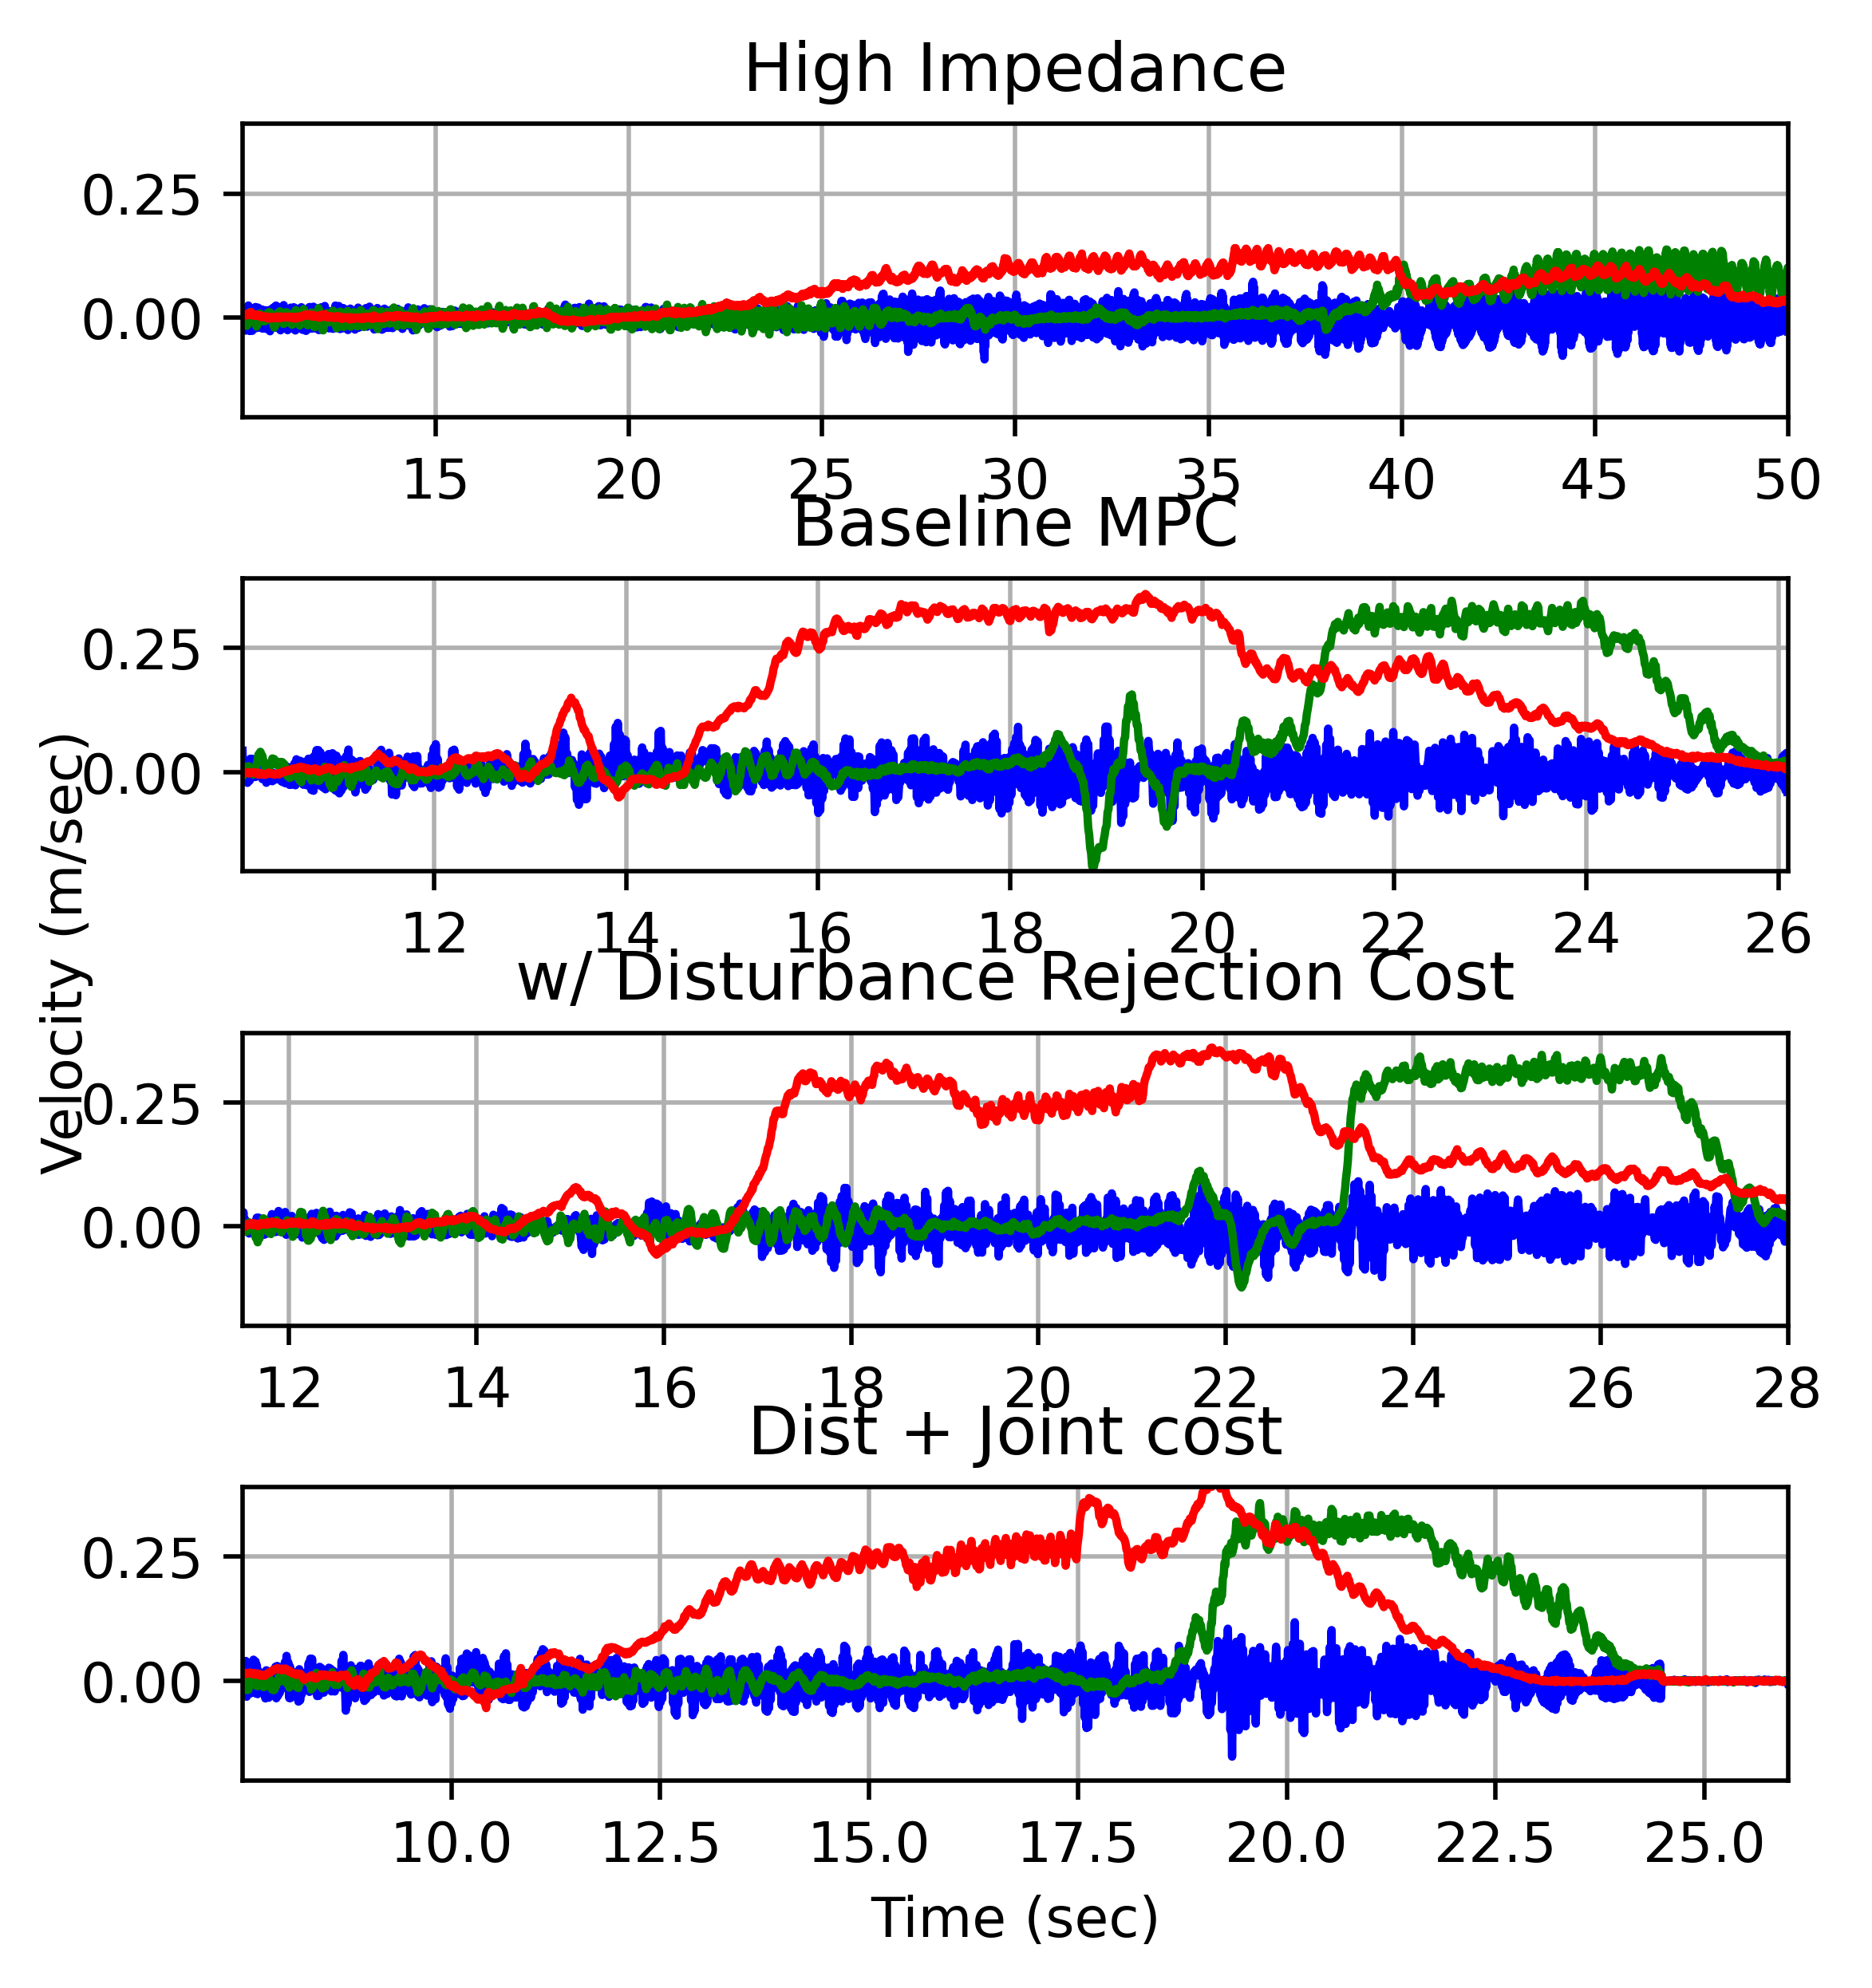

In [2]:
from scipy import signal

root = '../data/polish_flat2/'
baggies = ['validate_high_imp1.bag', 'validate_baseline1.bag', 'validate_dist1.bag', 'validate_jt3.bag']
namies = ['High Impedance', 'Baseline MPC', 'w/ Disturbance Rejection Cost', 'Dist + Joint cost']
timeies = [[10, 50],
           [10, 26.1],
           [11.5, 28.0],
           [7.5, 26]]

cutoff = 15

def butter_highpass(cutoff, fs, typ, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=typ, analog=False)
    return b, a

def butter_pass_filter(data, cutoff, fs, typ, order=5):
    b, a = butter_highpass(cutoff, fs, typ, order=order)
    y = signal.filtfilt(b, a, data)
    return y


fig, axs = plt.subplots(nrows = len(baggies), ncols = 1, figsize=(5,5.5))
for idx, (bag, name, times) in enumerate(zip(baggies, namies, timeies)):
    cols = ['r', 'g', 'b']
    dirs = ['X', 'Y', 'Z']
    msgs = bag_loader(root+bag, map_robot_state, topic_name = 'robot_state')
    low_freq_rms = 0
    high_freq_rms = 0
    
    for ind in (3,2,1):
        vel_lpf = butter_pass_filter(np.array(msgs['vel'][ind]),
                                         cutoff, 100, 'low')
        vel_hpf = butter_pass_filter(np.array(msgs['vel'][ind]),
                                         cutoff, 100, 'high')
        low_freq_rms += np.sum(vel_lpf**2)/len(vel_lpf)
        high_freq_rms += np.sum(vel_hpf**2)/len(vel_hpf)
                
        #st = 0 
        #en = len(msgs['t'])-1
        st = np.argmax(np.array(msgs['t'])>times[0])
        en = np.argmax(np.array(msgs['t'])>times[1])
        col = cols.pop()
        axs[idx].plot(msgs['t'][st:en], 10*np.array(msgs['vel'][ind,st:en]), col)
        axs[idx].set_xlim([msgs['t'][st], msgs['t'][en]])
        if False: # comment in to get the text on plots
            plt.text(0.3, 0.05, 'Low freq RMS:  {:.2E}'.format(low_freq_rms), 
             horizontalalignment='center', verticalalignment='center',
             transform = axs[idx].transAxes)
            plt.text(0.3, 0.16, 'High freq RMS: {:.2E}'.format(high_freq_rms),    
             horizontalalignment='center', verticalalignment='center',
             transform = axs[idx].transAxes)
    axs[idx].set_title(name)
    
#axs[0].legend()
for i in range(len(baggies)): axs[i].grid(True)
for i in range(len(baggies)): axs[i].set_ylim([-0.2, 0.39])

plt.xlabel('Time (sec)')
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('Velocity (m/sec)')
#plt.tight_layout()
plt.subplots_adjust(hspace=0.55)
fig.set_dpi(500)
plt.savefig("exp_polish_velocities.pdf")
plt.show()

Loading ros bag ../data/polish_flat2/validate_baseline_sim.bag  with 276 msgs on topic /impedance_gains_sim
Loading ros bag ../data/polish_flat2/validate_dist_sim.bag  with 368 msgs on topic /impedance_gains_sim
Loading ros bag ../data/polish_flat2/validate_jt_sim.bag  with 335 msgs on topic /impedance_gains_sim


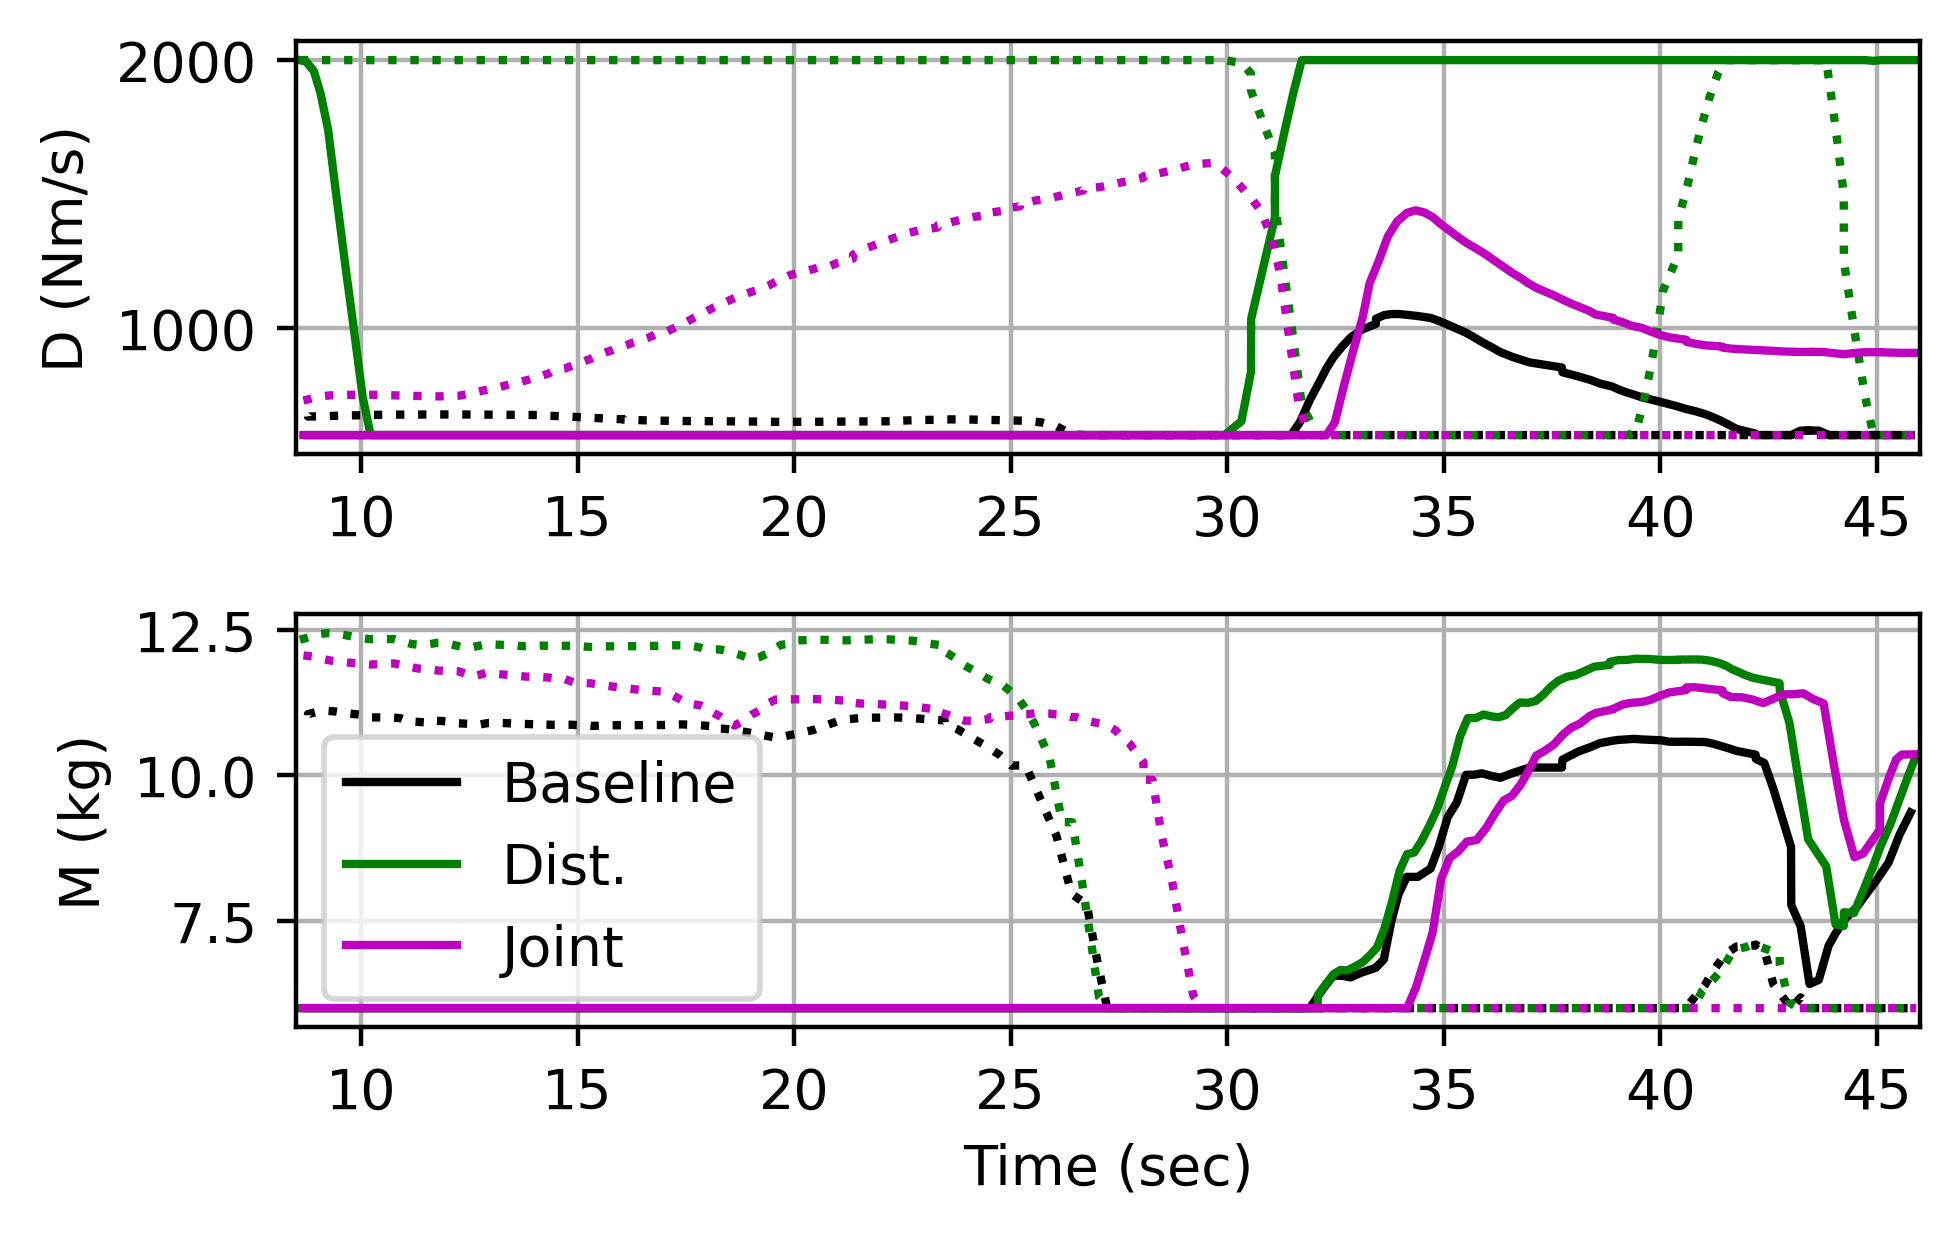

In [3]:
# Plotting the Impedance gains of the polishing task

# %matplotlib
path = '../data/polish_flat2/'
baggies = [ 'validate_baseline_sim.bag',
            'validate_dist_sim.bag',
            'validate_jt_sim.bag',
          ]  
namies = [ 'Baseline',
           'Dist.',
           'Joint'
         ]
fig, axs = plt.subplots(2, figsize=(5,3.2))
#fig.suptitle("Contact with GP-MPC")

cols = ['k', 'k:', 'g', 'g:', 'm', 'm:']
for bag, name in zip(baggies, namies):
    col = cols.pop(0)
    imp_msgs = bag_loader(path+bag, map_impedance_gains, topic_name = 'impedance_gains_sim')
    st = np.argmax(np.array(imp_msgs['t'])>8.5)
    rng = np.argmax(np.array(imp_msgs['t'])>46.0)
    #axs[0].plot(imp_msgs['t'], delta_imp_msgs['Fd'][ind], col, label = name)
    axs[0].plot(imp_msgs['t'][st:rng], imp_msgs['B'][1,st:rng], col)
    axs[1].plot(imp_msgs['t'][st:rng], imp_msgs['M'][1,st:rng], col, label = name)
    
    col = cols.pop(0)
    axs[0].plot(imp_msgs['t'][st:rng], imp_msgs['B'][2,st:rng], col)
    axs[1].plot(imp_msgs['t'][st:rng], imp_msgs['M'][2,st:rng], col)

axs[1].legend(loc='lower left')
for i in range(2): 
    axs[i].grid(True)
    axs[i].set_xlim((8.5, 46.0))
plt.xlabel('Time (sec)')
axs[0].set(ylabel='D (Nm/s)')#, title = 'Damping (top) and Inertia (Bottom)')
axs[1].set(ylabel='M (kg)')
plt.tight_layout()
fig.set_dpi(400)
plt.savefig("exp_polish_imp_time.pdf")
plt.show()